In [1]:
from IPython.display import HTML
HTML('''
<script>
code_show=false;
function code_toggle(){
    if(code_show){$('.prompt, .input, .output_stderr, .output_error').hide();}
    else{$('.input, .prompt, .output_stderr, .output_error').show();}
    code_show=!code_show;
}
function initialize(){
    var output=$('.output_subarea.output_text.output_stream.output_stdout');
    $.merge(output,$('.output_subarea.output_text.output_result'));
    for(var i=0;i<output.length;i++)for(var j=0;j<output[i].children.length;j++)
        output[i].children[j].style.fontFamily='Palatino';
    code_toggle();
}
$(document).ready(initialize);
</script>
Click <a href="javascript:code_toggle()">here</a> to show/hide codes in this notebook.
''')

# Error Propagation of Radon transform
Let $I \in \mathbb{N}^{r \times v}$ be a sinogram and the function $f: \mathbb{N}^{r \times v} \rightarrow \mathbb{N}^{n \times n}$ is the inverse radon transorm. Further be $F_x$ the Jacobian of $f$:
\begin{align}
    F_x &= \left[ \nabla f^T \right]^T &= \left[\begin{array}{c}
        f_1 \\
        \vdots \\
        f_{nn}
    \end{array}\right] \left[\begin{array}{ccc} \frac{\partial}{\partial I_1} & \dots & \frac{\partial}{\partial I_{rn}} \end{array}\right] &= \left[\begin{array}{ccc}
        \frac{\partial f_1}{\partial I_1} & \dots & \frac{\partial f_1}{\partial I_{rv}} \\
        \vdots & \ddots & \vdots \\
        \frac{\partial f_{nn}}{\partial I_1} & \dots & \frac{\partial f_{nn}}{\partial I_{rv}}
    \end{array}\right]
\end{align}

We now assume that $I$~$\mathcal{N}(\mu, \Sigma)$ is a realization of a multivariate normal distribution. The covariance matrix $\Sigma$ can be modelled in a way, that the correlation factor $\rho(i, j)$ is higher for columns $j$ and stays constant for rows $i$. We use exponential decay for the columns:
$$
    \rho(i) = exp( - \gamma i)
$$

The propagation of the uncertanty $\Sigma$ can be computed as followed:
$$
    \Sigma_f = F_x \Sigma F_x^T
$$

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as la
import tensorflow as tf
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))
print("CPUs Available: ", tf.config.list_physical_devices('CPU'))

import tensorflow_probability as tfp
from skimage import transform
from scipy.interpolate import interp1d
from error_propagation_radon_transform import utils

import importlib
importlib.reload(utils)

from ipywidgets import interact, widgets, interactive_output
from IPython.display import display

2024-06-10 12:14:58.988681: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 12:14:59.195145: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64
2024-06-10 12:14:59.195178: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-10 12:15:01.958886: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: c

GPUs Available:  []
CPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [2]:
num_angle = 179
num_spotx = 130
num_offset = 1

image_shape = (190, 1226)

chords = 'exact'

wepl = np.load('../../Data/simple_pCT/WEPL/WEPL_angles{:d}_offset{:d}_spotx{:d}_{:s}_{:d}_{:d}.npy'.format(num_angle, num_offset, num_spotx, chords, image_shape[0], image_shape[1]))

reconstruction_shape = (wepl.shape[0], wepl.shape[0])

print(wepl.shape)
print(reconstruction_shape)

(130, 179)
(130, 130)


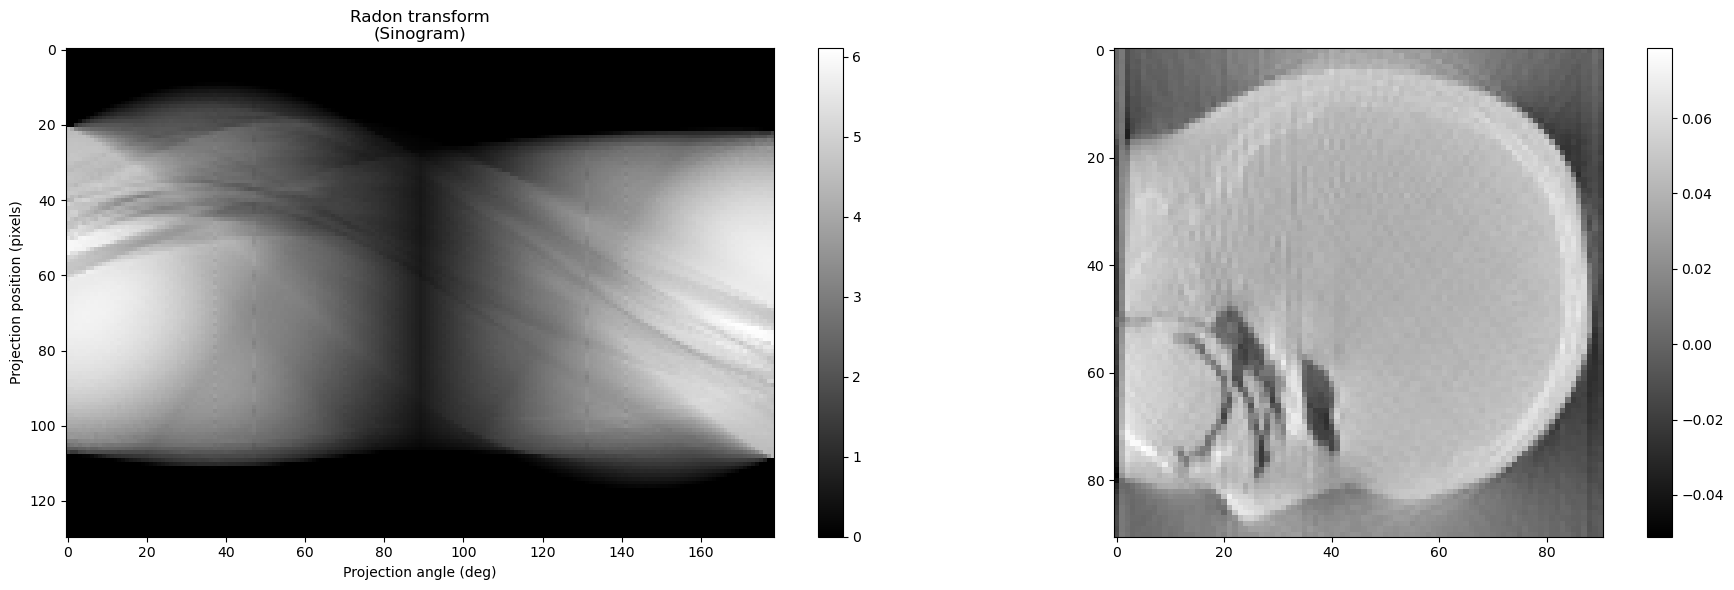

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

theta = np.linspace(0., 180., num_angle, endpoint=False)
ax1.set_title('Radon transform\n(Sinogram)')
ax1.set_xlabel('Projection angle (deg)')
ax1.set_ylabel('Projection position (pixels)')
sin = ax1.imshow(wepl, cmap='gray', aspect='auto')

plt.colorbar(sin, ax=ax1)

reconstructed = transform.iradon(wepl, theta=theta, filter_name='ramp', circle=False)
re = ax2.imshow(reconstructed, cmap='gray')
plt.colorbar(re, ax=ax2)

fig.tight_layout()
plt.show()

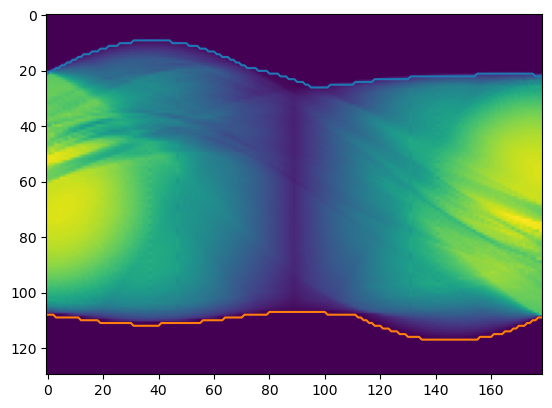

In [5]:
upper_edge = (wepl > 1e-2).argmax(axis=0)
lower_edge = wepl.shape[0] - np.flip(wepl > 1e-2, 0).argmax(axis=0)

plt.figure()
plt.imshow(wepl)
plt.plot(upper_edge)
plt.plot(lower_edge)
plt.show()

In [6]:
# ramp, shepp-logan, cosine, hamming, hann
filter_name = 'ramp'
width = 10

reconstructed = transform.iradon(wepl, theta=theta, filter_name=filter_name)

np.save('../../Data/simple_pCT/Reconstruction/Head/{:d}_{:d}/RSP_angles{:d}_offset{:d}_spotx{:d}_{:s}_{:s}.npy'.format(image_shape[0], image_shape[1], num_angle, num_offset, num_spotx, chords, filter_name), reconstructed)

In [7]:
jacobian, reconstructed = utils.compute_gradient(wepl, theta, reconstruction_shape, filter_name)


2024-06-10 12:21:52.133447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
np.save('../../Data/simple_pCT/Jacobian/J_angles{:d}_offset{:d}_spotx{:d}_{:s}_{:s}_{:d}_{:d}.npy'.format(num_angle, num_offset, num_spotx, chords, filter_name, image_shape[0], image_shape[1]), jacobian)


In [123]:
jacobian = np.load('../Data/simple_pCT/{:s}/J_angles{:d}_offset{:d}_spotx{:d}_{:s}_{:s}_{:d}_{:d}.npy'.format(experiment, num_angle, num_offset, num_spotx, chords, filter_name, image_shape[0], image_shape[1]))


In [9]:
l,m,n,o = jacobian.shape
jacobian_reshaped = tf.reshape(jacobian, (l*m, n*o))
print(jacobian.shape)

(130, 130, 130, 179)


In [10]:
@widgets.interact(phi=(0, wepl.shape[1], 1), t=(0, wepl.shape[0] - 1, 1))
def interact_imagespace(phi=0, t=0):
    plt.figure(figsize=(18,6))
    plt.imshow(tf.math.abs(jacobian[:,:,t,phi]))
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=0, description='phi', max=179), IntSlider(value=0, description='t', max=…

In [11]:
def exponential(value, gamma):
    return np.exp( - gamma * value)

/home/leonhardt/.conda/envs/ai/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3442: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


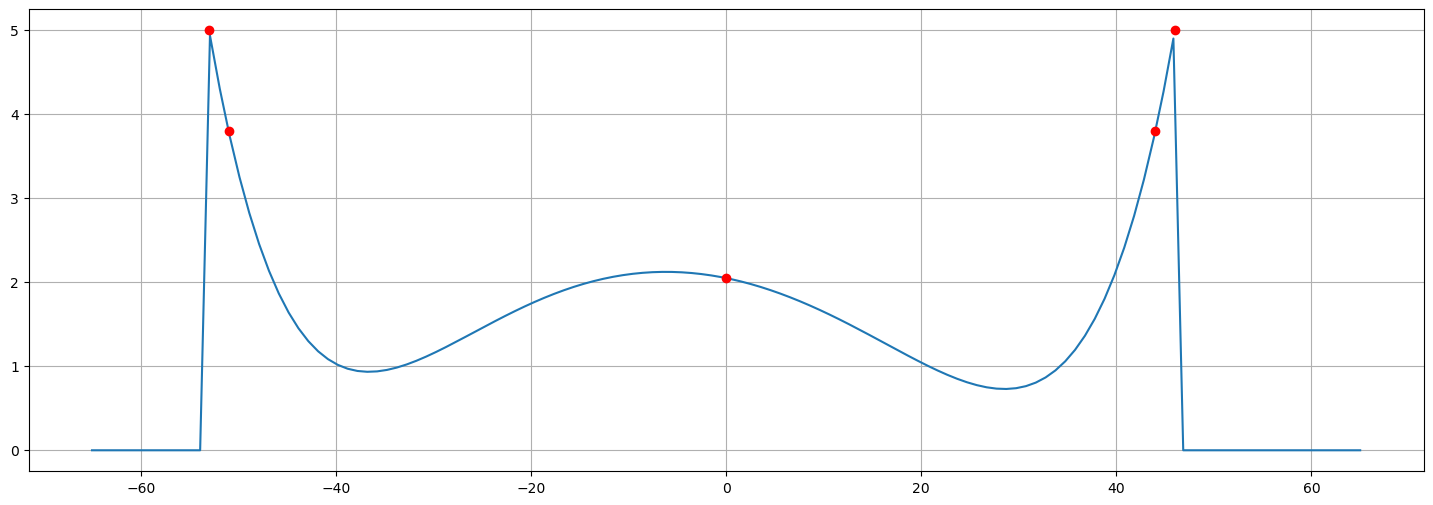

In [16]:
idx = 20
x_observed = [upper_edge[idx] - num_spotx//2, upper_edge[idx] + 2 - num_spotx//2, 0, lower_edge[idx] - 2 - num_spotx//2, lower_edge[idx] - num_spotx//2 ]
y_observed = np.array([ 5, 3.8, 2.05, 3.8, 5 ])
coeff = np.polyfit(x_observed, y_observed, 6)

x = np.linspace(-num_spotx//2, num_spotx//2, num_spotx)
polynom = np.poly1d(coeff)

y = polynom(x)
y[:upper_edge[idx]] = 0
y[lower_edge[idx]:] = 0

plt.figure(figsize=(18,6))
plt.plot(x, y)
plt.plot(x_observed, y_observed, 'ro')
plt.grid()
plt.show()

/home/leonhardt/.conda/envs/ai/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3442: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/leonhardt/.conda/envs/ai/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3442: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/leonhardt/.conda/envs/ai/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3442: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/leonhardt/.conda/envs/ai/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3442: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/leonhardt/.conda/envs/ai/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3442: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/leon

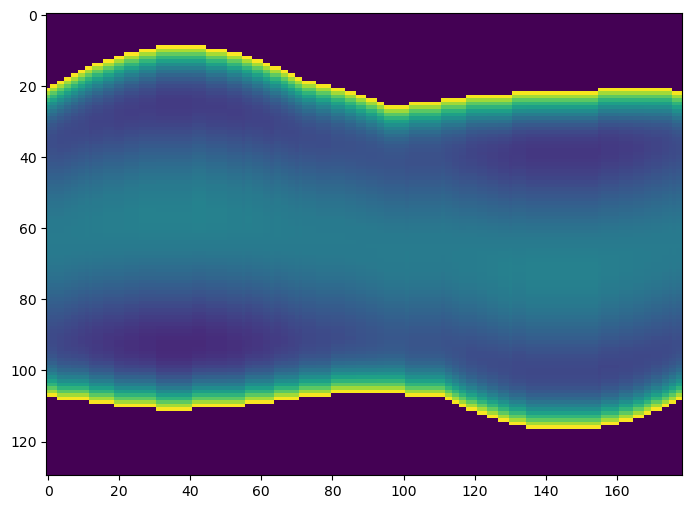

In [18]:
var = np.zeros_like(wepl)
for i in range(var.shape[1]):
    x_observed = [upper_edge[i] - num_spotx//2, upper_edge[i] + 2 - num_spotx//2, 0, lower_edge[i] - 2 - num_spotx//2, lower_edge[i] - num_spotx//2 ]

    y_observed = np.array([ 5, 3.8, 2.05, 3.8, 5 ])
    coeff = np.polyfit(x_observed, y_observed, 6)

    x = np.linspace(-num_spotx//2, num_spotx//2, num_spotx)
    polynom = np.poly1d(coeff)

    y = polynom(x)

    y[:upper_edge[i]] = 0
    y[lower_edge[i]:] = 0

    var[:,i] = y

plt.figure(figsize=(18,6))
plt.imshow(var)
plt.show()

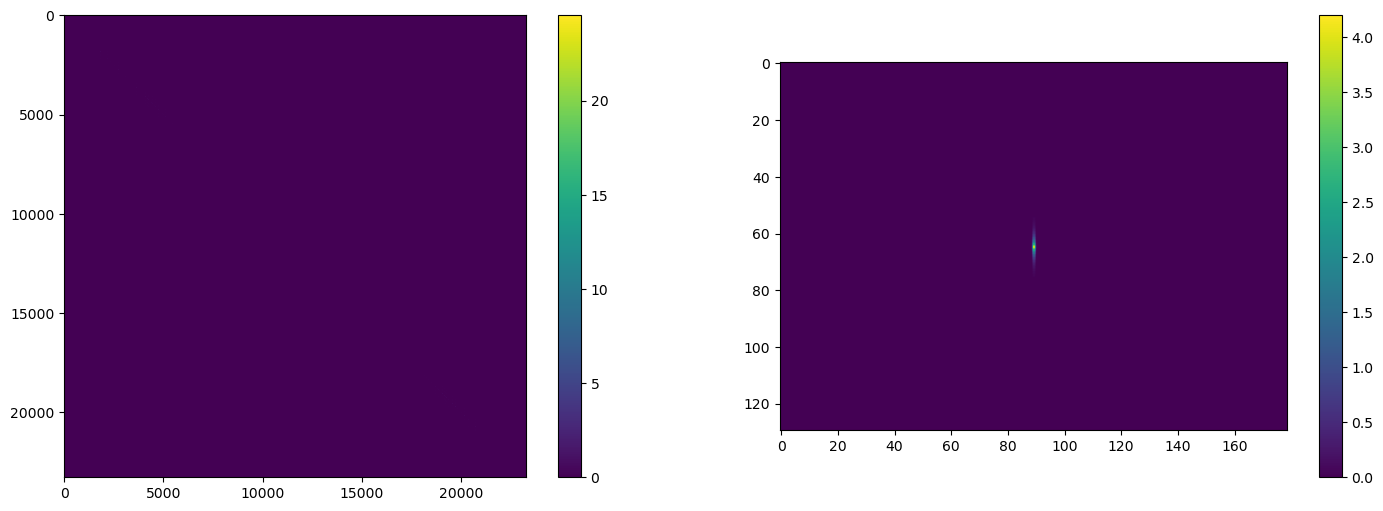

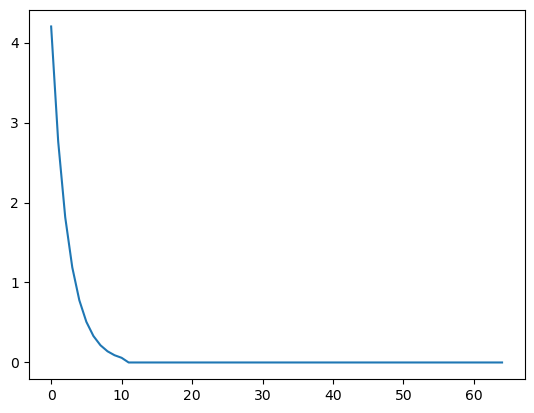

In [19]:
Sigma_in = utils.build_covariance_y(var**2, function=exponential, width=width)

impulse = np.zeros_like(var)
impulse[var.shape[0]//2, var.shape[1]//2] = 1.0

response = Sigma_in @ impulse.flatten()

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.imshow(Sigma_in)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(response.reshape(var.shape))
plt.colorbar()
plt.show()

plt.plot(response.reshape(var.shape)[var.shape[0]//2:, var.shape[1]//2])
plt.show()

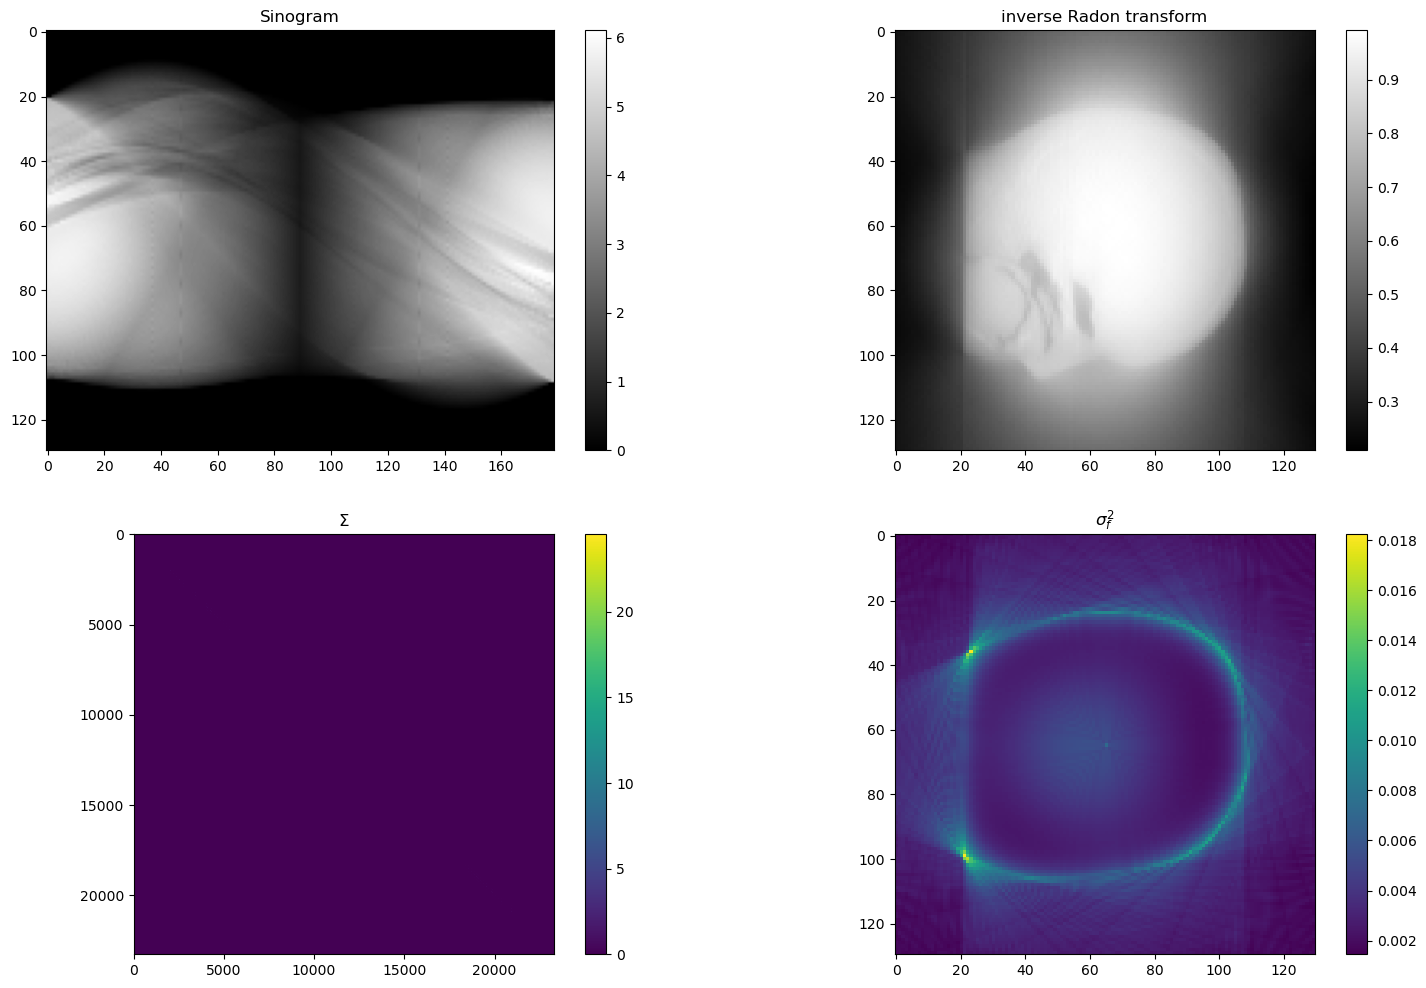

In [20]:
Sigma = jacobian_reshaped @ Sigma_in @ tf.transpose(jacobian_reshaped)

variance = tf.reshape(tf.abs(tf.linalg.tensor_diag_part(Sigma)), reconstruction_shape)

plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
plt.title('Sinogram')
plt.imshow(wepl, cmap='gray', aspect='auto')
plt.colorbar()

plt.subplot(2,2,2)
plt.title('inverse Radon transform')
plt.imshow(reconstructed, cmap='gray')
plt.colorbar()

plt.subplot(2,2,3)
plt.title(r'$\Sigma$')
plt.imshow(Sigma_in)
plt.colorbar()

plt.subplot(2,2,4)
plt.title(r'$\sigma^2_f$')
plt.imshow(variance)
plt.colorbar()

plt.show()

In [21]:
np.save('../../Data/simple_pCT/Sigma/Sigma_raedler_angles{:d}_offset{:d}_spotx{:d}_{:s}_{:s}_{:d}_{:d}.npy'.format(num_angle, num_offset, num_spotx, chords, filter_name, image_shape[0], image_shape[1]), Sigma)
